In [9]:
using Turing
using Distributions
using LinearAlgebra
using StatsFuns
using FastGaussQuadrature
using Bijectors
using HiddenMarkovModels
using DataFrames
using CSV
using Dates
using StatsAPI
using DensityInterface
using StatsPlots
using ReverseDiff
using Random
using MCMCChains

In [20]:
# --- load ---
df = CSV.read("../data/mouse_df.csv", DataFrame)

# --- pick mouse with most trials ---
trial_counts = combine(groupby(df, :name), nrow => :trial_count)
sort!(trial_counts, :trial_count, rev=true)
moi = trial_counts[1, :name]
mouse_df = df[df.name .== moi, :]

# --- drop omissions ---
if :outcome ∈ names(mouse_df)
    mouse_df = filter(:outcome => x -> x != "omission", mouse_df)
end

# --- drop invalid RTs (e.g., "NAN") ---
valid_rt_mask = .!(ismissing.(mouse_df.rt) .| (uppercase.(string.(mouse_df.rt)) .== "NAN"))
mouse_df = mouse_df[valid_rt_mask, :]

# coerce RTs to Float64
RTs = Float64.(mouse_df.rt)
choices = mouse_df.choice
outcomes = mouse_df.outcome
correct_side = mouse_df.correct_side

# coerce choices to 1 and 0
choices = Vector{Int}(map(x -> x == "right" ? 1 : 0, choices))
outcomes = Vector{Int}(map(x -> x == "correct" ? 1 : 0, outcomes))
correct_side = Vector{Int}(map(x -> x == "right" ? 1 : -1, correct_side))

12311-element Vector{Int64}:
 -1
  1
 -1
  1
  1
 -1
 -1
 -1
  1
  1
  ⋮
  1
 -1
  1
 -1
 -1
 -1
 -1
  1
 -1

In [14]:
# ---------------- WFPT ----------------
"""
    wfpt(t, v, B, w, τ; err=1e-12)

Wiener First Passage Time density (Navarro & Fuss, 2009).
Drift rate `v`, boundary separation `B`, relative start `w`, nondecision time `τ`.
"""
function wfpt(t::Real, v::Real, B::Real, w::Real, τ::Real; err::Real=1e-12)
    # Assumes unit diffusion (s_d = 1), bounds at 0 and B, start at z = w*B (0<w<1).
    if t <= τ
        return err  # numeric floor for log-likelihood stability
    end
    tt = (t - τ) / (B^2)

    # Navarro & Fuss style large-t / small-t switch
    kl = π * tt * err < 1 ?
        max(sqrt(-2 * log(π * tt * err) / (π^2 * tt)), 1 / (π * sqrt(tt))) :
        1 / (π * sqrt(tt))

    ks = 2 * sqrt(2 * π * tt) * err < 1 ?
        max(2 + sqrt(-2 * tt * log(2 * sqrt(2 * π * tt) * err)), sqrt(tt) + 1) :
        2

    p = zero(tt)
    if ks < kl
        # small-t image sum
        K  = ceil(Int, ks)
        lo = -floor(Int, (K - 1) / 2)
        hi =  ceil(Int, (K - 1) / 2)
        for k in lo:hi
            p += (w + 2k) * exp(-((w + 2k)^2) / (2tt))
        end
        p /= sqrt(2π * tt^3)
    else
        # large-t Fourier-sine series
        K = ceil(Int, kl)
        for k in 1:K
            p += k * exp(-(k^2) * π^2 * tt / 2) * sin(k * π * w)
        end
        p *= π
    end

    dens = p * exp(-v*B*w - (v^2) * (t - τ) / 2) / (B^2)
    return max(dens, err)
end

# WFPT wrappers for all four cases (Right = upper bound)
# wfpt_right_correct(t, v, B, w, τ; err=1e-8)   = wfpt(t,  v, B,   w, τ; err=err)
# wfpt_right_incorrect(t, v, B, w, τ; err=1e-8) = wfpt(t, -v, B, 1-w, τ; err=err)
# wfpt_left_correct(t, v, B, w, τ; err=1e-8)    = wfpt(t,  v, B, 1-w, τ; err=err)
# wfpt_left_incorrect(t, v, B, w, τ; err=1e-8)  = wfpt(t, -v, B,   w, τ; err=err)

wfpt_upper(t, v, B, w, τ; err=1e-8) = wfpt(t, -v, B, 1-w, τ; err=err)

wfpt_upper (generic function with 1 method)

In [ ]:
@model function Bayes_DDM(RTs::Vector{T}, choices::Vector{Int}, stim::Vector{Int}) where {T<:Real}
    # Priors
    ηB ~ Normal(log(1.2), 0.4)
    B  = exp(ηB)

    τ  ~ Uniform(0.0, 0.5)

    logv_mag ~ Normal(0.0, 1.5)
    v_mag    = exp(logv_mag)        # > 0

    w  ~ Beta(2, 2)

    @assert length(RTs) == length(choices) == length(stim)

    for i in eachindex(RTs)
        rt = RTs[i]
        s  = stim[i]                # -1 = left-favoring stimulus, +1 = right-favoring
        v  = s * v_mag              # signed drift for THIS trial

        if choices[i] == 1          # 1 = Right (upper)
            p = wfpt_upper(rt, v, B, w, τ; err=1e-12)
        else                        # 0 = Left (lower)
            p = wfpt(rt,        v, B, w, τ; err=1e-12)
        end
        Turing.@addlogprob! log(p)
    end
end

Bayes_DDM (generic function with 4 methods)

In [29]:
ddm = Bayes_DDM(RTs, choices, correct_side)
posterior_chains = sample(ddm, NUTS(), MCMCThreads(), 250, 4)

Sampling (4 threads)   0%|█                             |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0015347488261474383
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
Sampling (4 threads)   0%|█                             |  ETA: 0:07:50
Sampling (4 threads)   1%|█                             |  ETA: 0:03:56
Sampling (4 threads)   2%|█                             |  ETA: 0:02:38
Sampling (4 threads)   2%|█                             |  ETA: 0:01:59
Sampling (4 threads)   2%|█                             |  ETA: 0:01:36
Sampling 

Chains MCMC chain (250×19×4 Array{Float64, 3}):

Iterations        = 126:1:375
Number of chains  = 4
Samples per chain = 250
Wall duration     = 215.45 seconds
Compute duration  = 629.69 seconds
parameters        = ηB, τR, τ, logv_mag, w
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [30]:
describe(posterior_chains)

Chains MCMC chain (250×19×4 Array{Float64, 3}):

Iterations        = 126:1:375
Number of chains  = 4
Samples per chain = 250
Wall duration     = 215.45 seconds
Compute duration  = 629.69 seconds
parameters        = ηB, τR, τ, logv_mag, w
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64       Float64 

          ηB    0.0908    0.0044    0.0004   171.0919   137.7794    1.0229        0.2717
          τR    1.0384    0.8708    0.2196    18.6912    23.2171    1.1826        0.0297
           τ    0.1663    0.0006    0.0002    56.8506    13.4155    1.0811        0.0903
    logv_mag   -0.3343    0.0271    0.0012   553.4041   441.6117 

Bayesian-pDDM-HMM

In [5]:
# --- observation payload per time step ---
struct DDMObs{F<:Real, I<:Real}
    rt::F
    ch::I      # 1 = upper/right, 0 = lower/left
    cor::I     # 1 = correct, 0 = incorrect
end

# --- Emission "distribution" that calls wfpt_* densities ---
struct DDMEmission{F<:Real} <: ContinuousUnivariateDistribution 
    B::F
    V::F
    w::F
    τ::F
end

import Distributions: logpdf
function logpdf(d::DDMEmission, y::DDMObs)
    # Choose the right case and call existing density functions
    p = if y.ch == 1 && y.cor == 1
        wfpt_right_correct(y.rt, d.V, d.B, d.w, d.τ; err=1e-8)
    elseif y.ch == 1 && y.cor == 0
        wfpt_right_incorrect(y.rt, d.V, d.B, d.w, d.τ; err=1e-8)
    elseif y.ch == 0 && y.cor == 1
        wfpt_left_correct(y.rt, d.V, d.B, d.w, d.τ; err=1e-8)
    else
        wfpt_left_incorrect(y.rt, d.V, d.B, d.w, d.τ; err=1e-8)
    end
    return log(max(p, eps()))  # guard against underflow to 0.0
end

# --- HMM–pDDM model with multiple independent sequences integrated out ---
@model function pddm_hmm_hmmjl(RTs::Vector{<:Vector{<:Real}},
                               choices::Vector{<:Vector{<:Integer}},
                               outcomes::Vector{<:Vector{<:Integer}},  # == "corrects"
                               K::Int=2)

    @assert length(RTs) == length(choices) == length(outcomes)
    S = length(RTs)  # number of independent sequences

    # HMM priors (sticky transitions)
    α  ~ Exponential(1.0)            # stickiness; adds mass to the diagonal
    π0 ~ Dirichlet(ones(K))          # initial state distribution

    # Draw each row of A from a Dirichlet with extra mass on self-transition
    Trows = Vector{Vector}(undef, K)
    for k in 1:K
        a = ones(K) .+ zero(α)   # promote to Vector{Dual or Float64} depending on α
        a[k] += α
        Trows[k] ~ Dirichlet(a)
    end

    # HiddenMarkovModels.jl uses column-stochastic transitions; match the Turing example:
    A = copy(hcat(Trows...)')        

    # pDDM emission priors (state-specific), kept simple & positive via logs
    nB ~ MvNormal(fill(log(1.2), K), 1.0I) ; B = exp.(nB)   # boundary
    nV ~ MvNormal(fill(log(0.5), K), 1.0I) ; V = exp.(nV)   # drift scale
    w  ~ filldist(Beta(2, 2), K)                            # start bias in (0,1)

    τR ~ Exponential(1.0)                                   # upper bound for NDT
    τ  ~ filldist(Uniform(0.0, τR), K)

    # Build the emission distributions vector for the HMM
    emissions = [DDMEmission(B[k], V[k], w[k], τ[k]) for k in 1:K]

    # One HMM reused for all sequences (shared θ across sessions)
    hmm = HMM(π0, A, emissions)

    # Sum the sequence log-evidences (this integrates out the z's)
    for s in 1:S
        ys = [DDMObs(RTs[s][t], choices[s][t], outcomes[s][t]) for t in eachindex(RTs[s])]
        @addlogprob! logdensityof(hmm, ys)
    end
end


pddm_hmm_hmmjl (generic function with 4 methods)

In [6]:
hmmddm = pddm_hmm_hmmjl([RTs], [choices], [outcomes])
posterior_ddm = sample(hmmddm, NUTS(), MCMCThreads(), 250, 4)

Sampling (4 threads)   0%|█                             |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.013461935520172118
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
Sampling (4 threads)   0%|█                             |  ETA: 1:10:49
Sampling (4 threads)   1%|█                             |  ETA: 0:35:16
Sampling (4 threads)   2%|█                             |  ETA: 0:23:50
Sampling (4 threads)   2%|█                             |  ETA: 0:17:53
Sampling (4 threads)   2%|█                             |  ETA: 0:14:21
Sampling 

Chains MCMC chain (250×30×4 Array{Float64, 3}):

Iterations        = 126:1:375
Number of chains  = 4
Samples per chain = 250
Wall duration     = 5451.32 seconds
Compute duration  = 16721.11 seconds
parameters        = α, π0[1], π0[2], Trows[1][1], Trows[1][2], Trows[2][1], Trows[2][2], nB[1], nB[2], nV[1], nV[2], w[1], w[2], τR, τ[1], τ[2]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [7]:
describe(posterior_ddm)

Chains MCMC chain (250×30×4 Array{Float64, 3}):

Iterations        = 126:1:375
Number of chains  = 4
Samples per chain = 250
Wall duration     = 5451.32 seconds
Compute duration  = 16721.11 seconds
parameters        = α, π0[1], π0[2], Trows[1][1], Trows[1][2], Trows[2][1], Trows[2][2], nB[1], nB[2], nV[1], nV[2], w[1], w[2], τR, τ[1], τ[2]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
   parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ess_per_sec 
       Symbol   Float64   Float64   Float64    Float64    Float64   Float64       Float64 

            α    0.6869    0.6951    0.1202    29.0198   286.3671    1.1320        0.0017
        π0[1]    0.5396    0.2468    0.0688    14.0190   138.3203    1.4207        0.0008
        π0[2]    0.4604    0.2468    0.0688   

In [ ]:
# ---- Quadrature nodes/weights (choose orders) ----
const GH_N = 5                    # Hermite points (log-drift). 5–9 is typical.
const GL_N = 3                    # Legendre points (Uniform windows). 3 or 5 is typical.
const GH_x, GH_w = gausshermite(GH_N)
const GL_x, GL_w = gausslegendre(GL_N)

([-0.7745966692414834, 0.0, 0.7745966692414834], [0.5555555555555556, 0.8888888888888888, 0.5555555555555556])

In [8]:

# Expectation under Uniform(a,b): E[f(U)] via Gauss–Legendre
@inline function expect_uniform(f, a::Real, b::Real, x::AbstractVector, w::AbstractVector)
    mid  = (a + b) / 2
    half = (b - a) / 2
    acc  = 0.0
    @inbounds @simd for j in eachindex(x)
        acc += w[j] * f(mid + half * x[j])
    end
    return acc * 0.5
end

# Expectation under logv ~ Normal(m,s^2) of g(logv) via Gauss–Hermite
# E[g] = (1/√π) Σ w_i * g(m + √2 s x_i)
@inline function expect_log_normal(g, m::Real, s::Real, x::AbstractVector, w::AbstractVector)
    fac = sqrt(2.0) * s
    acc = 0.0
    @inbounds @simd for i in eachindex(x)
        acc += w[i] * g(m + fac * x[i])
    end
    return acc / sqrt(pi)
end

# ---- Marginalized per-trial likelihood (Rao–Blackwellized) ----
function wfpt_marginal_fast(rt::Real, ch::Int, cor::Int;
                            logv::Real, σ_logv::Real,
                            B::Real, w::Real, s_w::Real,
                            τ::Real, s_t::Real,
                            GHx::AbstractVector=GH_x, GHw::AbstractVector=GH_w,
                            GLx::AbstractVector=GL_x, GLw::AbstractVector=GL_w)

    ε = 1e-6
    lo_w = max(ε, w - 0.5*s_w); hi_w = min(1-ε, w + 0.5*s_w)
    lo_t = max(ε, τ - 0.5*s_t);  hi_t = τ + 0.5*s_t

    g = function(logv_i)
        v_i = exp(logv_i)
        fw = function(w_i)
            ft = function(τ_i)
                if ch == 1 && cor == 1
                    wfpt_right_correct(rt,  v_i, B, w_i, τ_i; err=1e-12)
                elseif ch == 1 && cor == 0
                    wfpt_right_incorrect(rt, v_i, B, w_i, τ_i; err=1e-12)
                elseif ch == 0 && cor == 1
                    wfpt_left_correct(rt,   v_i, B, w_i, τ_i; err=1e-12)
                else
                    wfpt_left_incorrect(rt, v_i, B, w_i, τ_i; err=1e-12)
                end
            end
            expect_uniform(ft, lo_t, hi_t, GLx, GLw)
        end
        expect_uniform(fw, lo_w, hi_w, GLx, GLw)
    end

    return expect_log_normal(g, logv, σ_logv, GHx, GHw)
end

# ---- Turing model with marginalized latents ----
@model function Bayes_DDM_RB_FGQ(RTs::Vector{T}, choices::Vector{Int}, corrects::Vector{Int};
                                 GHx::AbstractVector=GH_x, GHw::AbstractVector=GH_w,
                                 GLx::AbstractVector=GL_x, GLw::AbstractVector=GL_w) where {T<:Real}
    # Means / scales
    ηB   ~ Normal(log(1.2), 0.4);  B = exp(ηB)
    logτ ~ Normal(log(0.30), 0.5); τ = exp(logτ)
    w    ~ Beta(8, 8)

    logv    ~ Normal(0.0, 1.5)        # mean log-drift magnitude
    σ_logv  ~ Exponential(1.0)        # across-trial SD in logv

    s_w  ~ truncated(Normal(0.0, 0.10), 0, 0.9)  # start-point range
    s_t  ~ truncated(Normal(0.0, 0.10), 0, Inf)  # nondecision range

    λ ~ Beta(1, 50)  # small lapse
    tmin, tmax = minimum(RTs), maximum(RTs)
    Δt = max(tmax - tmin, eps())

    @assert length(RTs) == length(choices) && length(RTs) == length(corrects)

    for i in eachindex(RTs)
        rt, ch, cor = RTs[i], choices[i], corrects[i]
        p_wfpt = wfpt_marginal_fast(rt, ch, cor;
                                    logv=logv, σ_logv=σ_logv,
                                    B=B, w=w, s_w=s_w,
                                    τ=τ, s_t=s_t,
                                    GHx=GHx, GHw=GHw, GLx=GLx, GLw=GLw)
        p = (1 - λ)*p_wfpt + λ*(1/Δt)
        Turing.@addlogprob! log(p)
    end
end


Bayes_DDM_RB_FGQ (generic function with 2 methods)

In [9]:
model = Bayes_DDM_RB_FGQ(RTs, choices, outcomes)
posterior_chains_eddm = Turing.sample(model, NUTS(), MCMCThreads(), 1000, 8; adtype=AutoReverseDiff())

Sampling (8 threads)   0%|█                             |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0012096405029296876
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.008261394500732419
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.011183884739875798
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference

Chains MCMC chain (1000×22×8 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 8
Samples per chain = 1000
Wall duration     = 5706.23 seconds
Compute duration  = 36374.52 seconds
parameters        = ηB, logτ, w, logv, σ_logv, s_w, s_t, λ
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [10]:
describe(posterior_chains_eddm)

Chains MCMC chain (1000×22×8 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 8
Samples per chain = 1000
Wall duration     = 5706.23 seconds
Compute duration  = 36374.52 seconds
parameters        = ηB, logτ, w, logv, σ_logv, s_w, s_t, λ
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64       Float64 

          ηB   -0.0788    0.0059    0.0001   8738.5835   6089.4915    1.0003        0.2402
        logτ   -1.6605    0.0097    0.0002   4151.3212   4241.8999    1.0013        0.1141
           w    0.4930    0.0027    0.0000   9039.8690   5704.9183    1.0008        0.2485
        logv   -0.2581    0.0318 

AR Model of RTs

In [14]:
@model function ar_rts(RTs)
    β₁ ~ Normal(0, 1)
    β₀ ~ truncated(Normal(0, 1), 0, Inf)
    σ ~ Exponential(1)

    μ₀ ~ truncated(Normal(0, 1), 0, Inf)
    σ₀ ~ Exponential(1)

    for i in 1:length(RTs)
        if i == 1
            RTs[i] ~ Normal(μ₀, σ₀)
        else
            RTs[i] ~ Normal(β₀ + β₁ * RTs[i-1], σ)
        end
    end
end

ar_model = ar_rts(RTs)
sample_ar = sample(ar_model, NUTS(), 1000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
Sampling   1%|█                                         |  ETA: 0:18:36
Sampling   1%|█                                         |  ETA: 0:09:57
Sampling   2%|█                                         |  ETA: 0:07:27
Sampling   2%|█                                         |  ETA: 0:06:21
Sampling   3%|██                                        |  ETA: 0:05:52
Sampling   3%|██                                        |  ETA: 0:05:13
Sampling   4%|██                                        |  ETA: 0:04:53
Sampling   4%|██                                        |  ETA: 0:04:29
Sampling   5%|██                                        |  ETA: 0:04:05
Sampling   5%|███                                       |  ETA: 0:03:57
Sampling   6%|███                                       |  ETA: 0:03:52
Sam

Chains MCMC chain (1000×19×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 24.07 seconds
Compute duration  = 24.07 seconds
parameters        = β₁, β₀, σ, μ₀, σ₀
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [15]:
describe(sample_ar)

Chains MCMC chain (1000×19×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 24.07 seconds
Compute duration  = 24.07 seconds
parameters        = β₁, β₀, σ, μ₀, σ₀
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64       Float64 

          β₁    0.1101    0.0090    0.0007   174.2749   528.0690    1.0084        7.2412
          β₀    0.3726    0.0050    0.0003   247.3402   428.3336    0.9998       10.2772
           σ    0.3868    0.0024    0.0001   374.0111   492.8529    1.0062       15.5404
          μ₀    0.4230    0.3419    0.0157   302.8433   190.2358    1

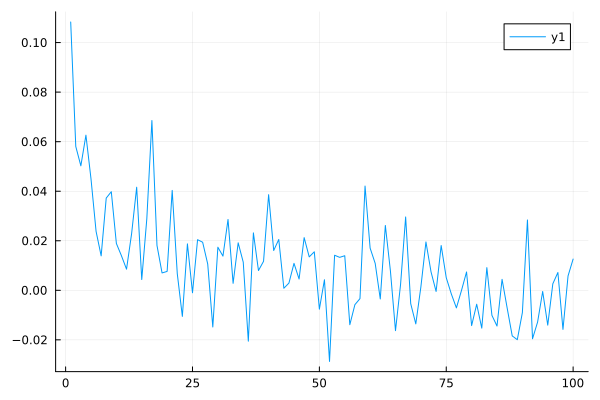

In [10]:
using StatsBase
plot(pacf(RTs, 1:100))